# Machine Learning Course Project
## Identifying User Stance On Social Media via Semi-Supervised Learning

### Overview

#### Midsem Pipeline - 

 - **Read Data**: Read text files to load all the words. 
 - **Clean Data**: Remove stop-words, everything lowercase, dehashify hashtags.
 - **Format Data**: Create data in a format required by each baseline method. 
 - **Baseline Approaches**: LSA, pLSA, Para2Vec, LDA Topic Modelling. The goal of these approaches is to create a "FIXED SIZE" and "HIGH LEVEL" feature representation for variable length tweets. These representations leverage our unlabelled data. 
 - **Training**: Some Supervised Learning on the learned representation using the given labels. 
 - **Evaluation**: Compare the different methods mentioned above on different datasets. 

#### Endsem Approaches - 
 - LDA2Vec - https://www.datacamp.com/community/tutorials/lda2vec-topic-model
 - Gaussian LDA - https://rajarshd.github.io/papers/acl2015.pdf
 - Word Embeddings Informed Topic Models - http://proceedings.mlr.press/v77/zhao17a/zhao17a.pdf
 
#### Reference
 - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Constants

In [1]:
# PATH_LABELLED_DATA_TRAINING = "../semeval2016-task6-domaincorpus/data-all-annotations/trainingdata-all-annotations.txt"
PATH_LABELLED_DATA_TRUMP = "../semeval2016-task6-domaincorpus/data-all-annotations/testdata-taskB-all-annotations.txt"
PATH_UNLABELLED_DATA_TRUMP = "./../semeval2016-task6-domaincorpus/downloaded_Donald_Trump.txt"

## Data 

In [2]:
# SETUP
# # Run in python console
# import nltk; nltk.download('stopwords')

# # Run in terminal or command prompt
# !python -m spacy download en

In [3]:
# !pip install gensim
# !pip install pyLDAvis

In [4]:
import pandas as pd
import numpy as np
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LsiModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['via'])

### Read Sem-Eval Task A Data (Labelled)

Interactive Visualization - http://www.saifmohammad.com/WebPages/StanceDataset.htm

Targets - 
 - Hilary Clinton
 - Atheism
 - Climate Change
 - Donald Trump
 - Feminism
 - Abortion

### Remove Symbols

In [6]:
def clean_tweets(sent):
    sent = str(sent)
    
    # Remove new line characters
    sent = re.sub('\s+', ' ', sent)

    # Remove distracting single quotes
    sent = re.sub("\'", "", sent)

    # Remove distracting single quotes
    sent = re.sub("\"", "", sent)

    # Remove hashtags
    sent = re.sub("\#", "", sent)

    # Remove http:// links
    sent = re.sub('http:\/\/.*','', sent)

    # Remove https:// links
    sent = re.sub('https:\/\/.*','', sent)
    
    # Remove emojis
#     emoji_pattern = re.compile("["
#         u"\U0001F600-\U0001F64F"  # emoticons
#         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#         u"\U0001F680-\U0001F6FF"  # transport & map symbols
#         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            "]+", flags=re.UNICODE)
    
#     sent = emoji_pattern.sub(r'', sent)
    
    return sent
    

In [7]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

data_X = pd.concat([X_train, X_test], ignore_index=True, axis=0)
data_y = pd.concat([y_train, y_test], ignore_index=True, axis=0)
data_labelled = pd.concat([data_X, data_y], ignore_index=True, axis=1)
data_labelled.columns = ['Tweet', 'Stance']
# data_labelled = pd.DataFrame([data_labelled], columns = ['Tweet', 'Stance'])
# data_labelled = data_labelled.where(data_labelled.Target != np.nan)

#### Data Stats

In [8]:
data_labelled.where(data_labelled.Stance == 'AGAINST').count()

Tweet     299
Stance    299
dtype: int64

In [9]:
data_labelled.where(data_labelled.Stance == 'NONE').count()

Tweet     299
Stance    299
dtype: int64

In [10]:
data_labelled.where(data_labelled.Stance == 'FAVOR').count()

Tweet     299
Stance    299
dtype: int64

### Read Sem-Eval Task B Data (Unlabelled)

In [11]:
data_unlabelled = pd.read_csv(PATH_UNLABELLED_DATA_TRUMP, sep='\t', lineterminator='\n', encoding ='latin1', names = ["ID", "Tweet"])
data_unlabelled = data_unlabelled.where(data_unlabelled.Tweet != 'Not Available')
data_unlabelled.dropna(how='any', inplace=True)
data_unlabelled['Tweet'] = data_unlabelled['Tweet'].apply(lambda x: x[1:])
data_unlabelled['Tweet'] = data_unlabelled['Tweet'].apply(clean_tweets)
# data_unlabelled = data_unlabelled[:1000]
# data_unlabelled['Tweet'] = data_unlabelled['Tweet'].str.decode('latin1')

In [12]:
combined_data = pd.concat([data_labelled], ignore_index=True)

In [13]:
combined_data.count()

Tweet     897
Stance    897
dtype: int64

In [14]:
combined_data.head(10)

,Tweet,Stance
0,Today & everyday I am proud to be an American....,AGAINST
1,@JonathanHoenig Why arent Americans allowed WE...,NONE
2,@toddstarnes Marriage is designed and defined ...,NONE
3,@realDonaldTrump we need someone like you who ...,FAVOR
4,@Dahat8 @Stonewall_77 The HATE within America ...,AGAINST
5,@Rene_gadeCowboy @danoroadblade yes but if a c...,NONE
6,@FFRNNU Maybe MSM should be talking more about...,AGAINST
7,@realDonaldTrump had a point and one the liber...,FAVOR
8,Did anyone cut ties with Senator Lindsey Graha...,AGAINST
9,"@GOP If you can not debate Trump, you should n...",FAVOR


In [15]:
df = combined_data['Tweet']
# df = data_labelled['Tweet']

In [16]:
data = df.values.tolist()
pprint(data[:1])

['Today & everyday I am proud to be an American. Im honored to be apart of the '
 'best the world has to offer! 4thofJuly SemST']


### Sentences To Words

In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['today',
  'everyday',
  'am',
  'proud',
  'to',
  'be',
  'an',
  'american',
  'im',
  'honored',
  'to',
  'be',
  'apart',
  'of',
  'the',
  'best',
  'the',
  'world',
  'has',
  'to',
  'offer',
  'thofjuly',
  'semst']]


### Create Bi-Grams Tri-Grams

In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['today', 'everyday', 'am', 'proud', 'to', 'be', 'an', 'american', 'im', 'honored', 'to', 'be', 'apart', 'of', 'the', 'best', 'the', 'world', 'has', 'to', 'offer', 'thofjuly', 'semst']


### Remove Stop Words and Lemmatize

WE NEED PRONOUNS FOR STANCE

In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PRON']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PRON'])

print(data_lemmatized[:1]), print(len(data_lemmatized))

[['today', 'everyday', 'proud', '-PRON-', 'be', 'honor', 'apart', 'good', 'world', 'offer', 'thofjuly', 'semst']]
897


(None, None)

## Format Data

In [21]:
# Create Corpus
texts = data_lemmatized

def read_corpus(texts, tokens_only=False):
    for i, line in enumerate(texts):
        if tokens_only:
            yield line
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(line, [i])

corpus = list(read_corpus(texts))

In [22]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [23]:
model.build_vocab(corpus)

In [24]:
%time model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 1.13 s, sys: 26.4 ms, total: 1.16 s
Wall time: 1.17 s


In [25]:
# vectors = read_corpus(corpus, tokens_only=True)

## Evaluation

### Format Labelled Data

In [26]:
labelled_corpus = corpus[-897:]
len(labelled_corpus)

897

### Create Dataset for Supervised Learning

In [27]:
mallet_feats = []

for i in range(len(labelled_corpus)):
    representation = model.infer_vector(labelled_corpus[i].words)
    mallet_feats.append(representation)

In [28]:
STANCES = ['AGAINST', 'FAVOR', 'NONE']

In [29]:
def transform_labels(label):
    if label == 'AGAINST':
        return 0
    elif label == 'FAVOR':
        return 1
    elif label == 'NONE':
        return 2

In [30]:
# labelled_stance = combined_data.Stance[53616:54323]
labelled_stance = data_labelled['Stance']
labelled_stance = labelled_stance.apply(transform_labels)
labelled_stance = labelled_stance.tolist()

In [31]:
len(mallet_feats[0]), len(mallet_feats)

(50, 897)

## Supervised Learning

In [32]:
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import argparse
from sklearn.utils.multiclass import unique_labels

In [33]:
## Create Train Test Split
X_train = mallet_feats[:627]
X_test = mallet_feats[627:]
y_train = labelled_stance[:627]
y_test = labelled_stance[627:]

In [34]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [35]:
def RandomForest(X_train, X_test, y_train, y_test):
    
    # GRID SEARCH
    parameters = {'n_estimators':range(100,600,100), 'max_depth':range(1,20,5)}
    rlf = RandomForestClassifier(random_state=0)
    rlf = GridSearchCV(rlf, parameters, cv=5)
    rlf.fit(X_train, y_train)
    
    y_pred = rlf.predict(X_test)

    rf_cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, classes=STANCES,
                      title='Confusion matrix, without normalization')

    rf_cv = cross_val_score(rlf, X_train, y_train, cv=5, scoring='f1_macro')
    report = {}
    report["RF_cross_val_score"] = rf_cv.tolist()
    report["RF_mean_acc"] = rf_cv.mean()
    report["RF_std_acc"] = rf_cv.std()*2
    report["RF_params"] = rlf.cv_results_
    
    report["RF_CM"] = rf_cm.tolist()

    
    return report

In [36]:
def SVMClassifier(X_train, X_test, y_train, y_test):

    parameters = {'kernel':['linear','rbf','poly'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    
    clf = svm.SVC(gamma='auto')
    clf = GridSearchCV(clf, parameters, cv=5)
    clf.fit(X_train, y_train)
    
    clf_cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')
    report = {}
    report["SVM_cross_val_score"] = clf_cv.tolist()
    report["SVM_mean_acc"] = clf_cv.mean()
    report["SVM_std_acc"] = clf_cv.std()*2
    report["SVM_params"] = clf.cv_results_

    
    y_pred = clf.predict(X_test)

    clf_cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, classes=STANCES,
                      title='Confusion matrix, without normalization')

    report["SVM_CM"] = clf_cm.tolist()

    
    return report
    

Confusion matrix, without normalization
[[59 11 18]
 [ 6 76 10]
 [ 5  8 77]]
{'RF_cross_val_score': [0.7794734247943896, 0.7394613457671125, 0.7142660106515528, 0.7517489128379656, 0.763321731222157], 'RF_mean_acc': 0.7496542850546356, 'RF_std_acc': 0.044150593397224325, 'RF_params': {'mean_fit_time': array([0.16073227, 0.25824914, 0.43398123, 0.68975163, 0.78171763,
       0.28928928, 0.47007365, 0.66703343, 0.82642102, 1.03467565,
       0.24991603, 0.47931237, 0.70511723, 0.95147424, 1.17954788,
       0.24656277, 0.48630953, 0.74260912, 1.23139558, 1.34026442]), 'std_fit_time': array([0.03198381, 0.00636198, 0.04193589, 0.11831808, 0.14366058,
       0.06083514, 0.02077167, 0.07081836, 0.02101496, 0.01552898,
       0.029599  , 0.02258662, 0.02101132, 0.03989177, 0.03446149,
       0.02193785, 0.03366213, 0.03076365, 0.27210385, 0.08271448]), 'mean_score_time': array([0.00789824, 0.01252127, 0.03057241, 0.03462358, 0.04630671,
       0.00962801, 0.01580176, 0.02088823, 0.02744017, 

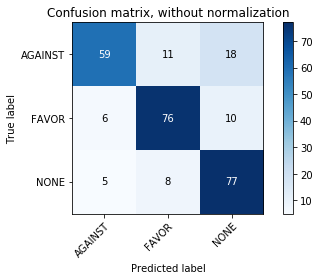

In [37]:
mallet_report = RandomForest(X_train, X_test, y_train, y_test)
print(mallet_report)

Confusion matrix, without normalization
[[56 10 22]
 [16 63 13]
 [24  7 59]]
{'SVM_cross_val_score': [0.7294668429169421, 0.6435700750858775, 0.6837483238544412, 0.6571715527541602, 0.6244042945073872], 'SVM_mean_acc': 0.6676722178237615, 'SVM_std_acc': 0.07288515522430791, 'SVM_params': {'mean_fit_time': array([0.01651273, 0.02396579, 0.01671333, 0.01621618, 0.02272854,
       0.01717324, 0.01536016, 0.02321315, 0.01791716, 0.01436486,
       0.0233994 , 0.01717548, 0.01442523, 0.0216846 , 0.01871586,
       0.02371244, 0.01922178, 0.0167758 , 0.10985637, 0.01959352,
       0.01679649]), 'std_fit_time': array([0.00143342, 0.00194614, 0.00018665, 0.00105307, 0.00045939,
       0.00083097, 0.00012731, 0.00122972, 0.00088759, 0.00091641,
       0.00113635, 0.00108655, 0.00119255, 0.00098642, 0.00047478,
       0.00083737, 0.00026389, 0.00021682, 0.01698905, 0.00063054,
       0.00023783]), 'mean_score_time': array([0.00290747, 0.00427299, 0.00312157, 0.00284448, 0.0040112 ,
       0.0032

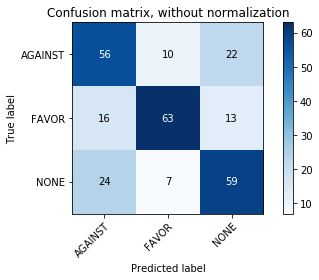

In [38]:
mallet_report = SVMClassifier(X_train, X_test, y_train, y_test)
print(mallet_report)